In [1]:
!pip install pandarallel torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.5 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16677 sha256=22962b5e72f1e3f3d90ee2b41bec4c3245399d3a347e5f4107956e1a1b1dbc36
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [2]:
ROOT_PATH = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project"

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import json


In [4]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors, use_memory_fs=False, progress_bar=True)

Available CPUs: 4
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
TRAIN_JSONL_PATH = os.path.join(ROOT_PATH, "data_raw/train.jsonl")
EVAL_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/dev.jsonl")
TEST_JSONL_PATH =  os.path.join(ROOT_PATH, "data_raw/test.jsonl")

### Read the Data

In [7]:
def read_jsonl(path):
    # Open the JSONL file
    with open(path, 'r') as file:
        data_list = []
        
        # Read each line in the file
        for line in file:
            # Parse the JSON data from each line
            data = json.loads(line)
            
            # Append the JSON data to the list
            data_list.append(data)

    # Create a Pandas DataFrame from the list of JSON objects
    df = pd.DataFrame(data_list)
    return df

train = read_jsonl(TRAIN_JSONL_PATH)
eval_df = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

In [8]:
train["dataset"] = "train"
eval_df["dataset"] = "eval"
test["dataset"] = "test"

df = pd.concat([train, eval_df, test], ignore_index=True)
df.head()

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train


In [9]:
del train
del eval_df
del test

In [10]:
# replace the values in the label column from 0,1 to non_hateful and hateful
df["label"] = df["label"].replace({0.0: "non_hateful", 1.0: "hateful"})

In [11]:
df["img"] = os.path.join(ROOT_PATH, "data_raw/") + df["img"].astype(str)

In [12]:
df["img"][1]

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_raw/img/23058.png'

### Organize the data

In [13]:
import os

# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [14]:
ROOT_PATH

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project'

In [16]:
print(f"gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed {ROOT_PATH}/")

gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed /content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/


In [15]:
## TAKES APPROX. 3 MINS
# Copy the files from GCS to the current working directory in colab
os.system(f'gsutil -m cp -r gs://machine-learning-spring-2023/data_preprocessed {ROOT_PATH}/')
# os.system('gsutil cp -r gs://mybucket/folder2 .')
# os.system('gsutil cp -r gs://mybucket/folder3 .')

2

In [ ]:
TARGET_MODEL_DATAPATH = "/content/drive/MyDrive/UChicago_MachineLearning"

In [ ]:
df[(df['dataset'] == "train") & (df['label'] == "hateful")]['img'].iloc[0]

'/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_raw/img/79351.png'

In [ ]:
import os
import shutil

unique_datasets = df['dataset'].unique()

for dataset in unique_datasets:
    dataset_folder = os.path.join(TARGET_MODEL_DATAPATH, "data_preprocessed", dataset)
    print(dataset_folder)
    os.makedirs(dataset_folder, exist_ok=True)

    dataset_classes = df[df['dataset'] == df]['label'].unique()
    if len(dataset_classes) == 1:
        continue

    for class_name in dataset_classes:
        print(class_name)
        class_folder = os.path.join(dataset_folder, str(class_name))
        os.makedirs(class_folder, exist_ok=True)

        class_images = df[(df['dataset'] == dataset) & (df['label'] == class_name)]['img']
        print(class_images.shape)
        for image_path in class_images:
            image_name = os.path.basename(image_path)
            destination_path = os.path.join(class_folder, image_name)
            shutil.copy(image_path, destination_path)
        

print("Image copying completed successfully.")

/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/train


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/eval


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/test


<ipython-input-51-cd17501b54f3>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  dataset_classes = df[df['dataset'] == df]['label'].unique()


Image copying completed successfully.


In [ ]:
gsutil cp -r gs://machine-learning-spring-2023/data_preprocessed .


In [ ]:
%ls "/content/drive/MyDrive/UChicago_MachineLearning/data_preprocessed/train"

In [ ]:
df = df.head(1000)

### Pixel Processing

In [ ]:
def crop_center(img):
    y, x, _ = img.shape
    startx = x//2-(224//2)
    starty = y//2-(224//2)    
    return img[starty:starty+224, startx:startx+224, :]

In [ ]:
%ls -al

total 20
drwxr-xr-x 1 root root 4096 May 23 20:19 ./
drwxr-xr-x 1 root root 4096 May 23 20:03 ../
drwxr-xr-x 4 root root 4096 May 22 13:32 .config/
drwx------ 6 root root 4096 May 23 20:19 drive/
drwxr-xr-x 1 root root 4096 May 22 13:33 sample_data/


In [ ]:
from PIL import Image

def load_image_pixels(image_path):
    # Open the image file
    try:
        with Image.open(image_path) as img:
            # Convert the image to RGB (if it's not already in that format)
            img = img.convert('RGB')
            # Get the pixel values as a numpy array and flatten it
            pixels = np.array(img)
            pixels = crop_center(pixels)
            pixels = np.divide(pixels, 255)
            pixels = np.squeeze(pixels
                                )
            return pixels
    except:
        return ""


# Add a new column 'pixels' to the DataFrame
df['pixels'] = df['img'].parallel_apply(load_image_pixels)

In [ ]:
output_path = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/image_pixels.pkl"

In [ ]:
df.to_pickle(output_path)

### Read the Pixel Data

In [20]:
output_path = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/image_pixels.pkl"

In [22]:
df = pd.read_pickle(output_path)

In [23]:
print("Length before processing: ", df.shape)
df = df[df.pixels != ""]
print("Length after processing: ", df.shape)


Length before processing:  (10000, 6)
Length after processing:  (4042, 6)


/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [24]:
df = df.head(1000)

### Modeling

In [25]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
df["pixels"][0].shape

(224, 224, 3)

In [26]:
import numpy as np
from torchvision import transforms

def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation of a dataset.
    
    Args:
        dataset: PyTorch dataset object.
        
    Returns:
        mean: List of mean values for each channel.
        std: List of standard deviation values for each channel.
    """
    # Initialize lists to store channel-wise mean and std
    mean = [0.0, 0.0, 0.0]
    std = [0.0, 0.0, 0.0]

    # Loop over the dataset to calculate mean and std
    for image in dataset:
        for i in range(3):  # Assuming 3 channels (RGB)
            mean[i] += image[:, :, i].mean()
            std[i] += image[:, :, i].std()

    # Calculate the average mean and std across the dataset
    mean = [m / len(dataset) for m in mean]
    std = [s / len(dataset) for s in std]

    return mean, std

# Calculate the mean and std for the training set
mean, std = calculate_mean_std(df['pixels'])

In [27]:
mean, std

([0.5211238887569434, 0.46482455464967737, 0.4327499024649817],
 [0.2448677329966468, 0.2377475702818632, 0.2375984268656204])

### Transformation

In [51]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224

        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
}

data_dir = "/content/drive/MyDrive/UChicago_MachineLearning/Machine_Learning/Final_Project/data_preprocessed/train"

image_datasets = {x: datasets.ImageFolder(data_dir,
                                          data_transforms[x])
                  for x in ['train', 'eval']}

In [52]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=3)
              for x in ['train', 'eval']}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

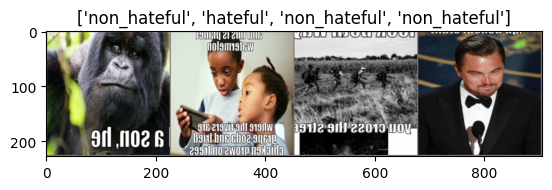

In [53]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean, std, title=[class_names[x] for x in classes])

### Training

In [65]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_per_epoch = []
    eval_loss_per_epoch = []

    train_acc_per_epoch = []
    eval_acc_per_epoch = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss_per_epoch.append(epoch_loss)
                train_acc_per_epoch.append(epoch_acc.item())
            elif phase == 'eval':
                eval_loss_per_epoch.append(epoch_loss)
                eval_acc_per_epoch.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {"train_losses": train_loss_per_epoch, 
                   "test_losses": eval_loss_per_epoch,
                   "train_accuracies": train_acc_per_epoch,
                   "eval_accuracies": eval_acc_per_epoch
                   }

In [66]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [67]:
device

device(type='cuda', index=0)

In [68]:
%%time

try:
    model_ft, metrics = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)
except Exception as e:
    raise Exception(e)
finally:
    print(metrics)

Epoch 0/19
----------
train Loss: 0.8379 Acc: 0.5698
eval Loss: 0.7174 Acc: 0.5104

Epoch 1/19
----------
train Loss: 0.7186 Acc: 0.6016
eval Loss: 0.6572 Acc: 0.6455

Epoch 2/19
----------
train Loss: 0.7006 Acc: 0.6111
eval Loss: 0.6615 Acc: 0.6257

Epoch 3/19
----------
train Loss: 0.6910 Acc: 0.6142
eval Loss: 0.6979 Acc: 0.6439

Epoch 4/19
----------
train Loss: 0.6741 Acc: 0.6260
eval Loss: 0.6712 Acc: 0.6521

Epoch 5/19
----------
train Loss: 0.6755 Acc: 0.6247
eval Loss: 0.6377 Acc: 0.6588

Epoch 6/19
----------
train Loss: 0.6686 Acc: 0.6263
eval Loss: 0.6458 Acc: 0.6411

Epoch 7/19
----------
train Loss: 0.6393 Acc: 0.6530
eval Loss: 0.6303 Acc: 0.6630

Epoch 8/19
----------
train Loss: 0.6390 Acc: 0.6507
eval Loss: 0.6386 Acc: 0.6607

Epoch 9/19
----------
train Loss: 0.6347 Acc: 0.6578
eval Loss: 0.6354 Acc: 0.6634

Epoch 10/19
----------
train Loss: 0.6341 Acc: 0.6587
eval Loss: 0.6421 Acc: 0.6583

Epoch 11/19
----------
train Loss: 0.6331 Acc: 0.6594
eval Loss: 0.6272 Acc

In [74]:
def visualize_model(model, mean, std, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j], mean=mean, std=std)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

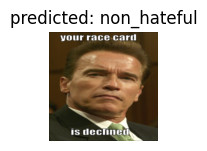

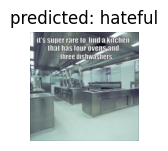

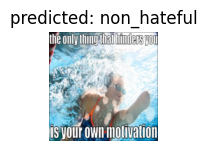

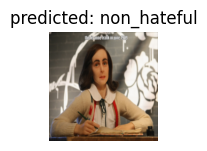

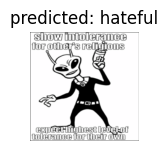

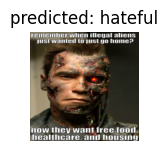

In [77]:
visualize_model(model_ft, mean=mean, std=std)